In [ ]:
!pip install opencc-python-reimplemented
import time
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import jieba
from opencc import OpenCC  #pip install opencc-python-reimplemented

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
path_to_file = pathlib.Path('/content/transformer/cmn.txt')
path_to_file


PosixPath('/content/transformer/cmn.txt')

In [ ]:
#数据格式如上图所示
#定义一个方法，加载数据文本，并把数据分成输入(中文）数据集，和输出(英文）数据集
def load_data(path):
    targ = [] #建立输出数据集 列表形式
    inp = [] #建立输入数据集 列表形式
    text = path.read_text(encoding='utf-8') #读取文件
    lines = text.splitlines() #以行为单位读取所有数据
    #读取每行数据，用\t进行分割，只取前两个数据。
    pairs = [line.split('\t')[:2] for line in lines]
    for y, x in pairs: #读取pairs的每一数据
        targ.append(y) #把第一个数据英文加入到targ
        inp.append(x)  #把第二个数据中文加入到inp
    return targ, inp

In [ ]:
targ, inp = load_data(path_to_file)
print(len(inp))
print(len(targ))
print(inp[-10:])
print(targ[-10:])

FileNotFoundError: [Errno 2] No such file or directory: '/content/transformer/cmn.txt'

In [ ]:
#使用OpenCC('t2s') 繁体变简体的方法
cc = OpenCC('t2s')

In [ ]:
#定义一个方法，用于把繁体转换成简体，并对句子进行分词。
def proce_cn_sentence(cn_text):
    text = cc.convert(cn_text) #繁体转换成简体
    text = jieba.lcut(text) #读取数据集里的每个数据并进行分词
    text = ' '.join(text) #对分好的词用空格链接起来
    return text

In [ ]:
#由于中文是连续的，我们要进行分词，并把每个词语之间加入空格
for i in range(len(inp)):
    text = proce_cn_sentence(inp[i]) #读取数据集里的每个数据并进行分词
    inp[i] = text #用分词好的数据替换数据集中原先的数据

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.010 seconds.
DEBUG:jieba:Loading model cost 1.010 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
inp[-10:] #我们在来看看inp数据集里的数据


['菲律宾 去年 地震 和 海啸 造成 了 超过 6000 人 的 死亡 。',
 '“ 又 是 汤姆 的 电话 ？ ”   “ 嗯 。 最近 他 每天晚上 都 会 打 过来 。 当时 就 不该 给 他 我 的 号码 的 。 ”',
 '我 母亲 的 法语 比 我 父亲 的 英语 要 好 ， 所以 他们 通常 用 法语 交流 。',
 '汤姆 不知 如何 翻译 “ 计算机 ” 一词 ， 因为 同 他 谈话 的 人 从未见过 一台 。',
 '汤姆 不 喜欢 使用 ” 有色人种 “ 这个 术语 ， 因为 他 认为 ， 根据 这种 说法 白种人 没有 颜色 。',
 '你 不想 涂 防晒霜 是 你 的 问题 ， 但是 晒伤 了 不要 来 抱怨 。',
 '即使 是 现在 ， 我 偶尔 还是 想 见到 你 。 不是 今天 的 你 ， 而是 我 记忆 中 曾经 的 你 。',
 '你 很 容易 把 母语 说 得 通顺 流畅 ， 却 很 容易 把 非 母语 说 得 不 自然 。',
 '虽然 我 被 公司 解雇 了 ， 但是 我 还 有点 存款 ， 所以 目前 不用 担心 生计 问题 。',
 '如果 一个 人 在 成人 前 没有 机会 习得 目标语言 ， 他 对 该 语言 的 认识 达到 母语 者 程度 的 机会 是 相当 小 的 。']

In [ ]:
#定义两个常量
BUFFZE_SIZE = len(inp)
print(BUFFZE_SIZE)
BATCH_SIZE = 64

29909


In [ ]:

#把inp和targ加入到dataset中变成tensor这样有利于tensorflow读取
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFZE_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
#我们看下dataset中数据的样式
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:3])
    print()
    print(example_target_batch[:3])
    break

tf.Tensor(
[b'\xe4\xba\xba\xe7\x94\x9f \xe8\x89\xaf\xe8\x8b\xa6 \xe3\x80\x82'
 b'\xe4\xbd\xa0 \xe6\x98\xaf \xe8\xae\xa4\xe7\x9c\x9f \xe7\x9a\x84 \xe5\x90\x97 \xef\xbc\x9f'
 b'\xe8\xbf\x99\xe4\xb8\xaa \xe8\x8b\xb9\xe6\x9e\x9c \xe6\x98\xaf \xe5\x9d\x8f \xe7\x9a\x84 \xe3\x80\x82'], shape=(3,), dtype=string)

tf.Tensor([b'Life is very hard.' b'Are you serious?' b'This apple is bad.'], shape=(3,), dtype=string)


In [ ]:
#该方法主要是给中文每个句子加上start和end
def tf_lower_and_split_punct_cn(text):
    #大写变小写
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text



In [ ]:
example_text = tf.constant('去年 在 菲律宾 ， 地震 和 海啸 造成 了 超过 6000 人 的 死亡 。')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct_cn(example_text).numpy().decode())

去年 在 菲律宾 ， 地震 和 海啸 造成 了 超过 6000 人 的 死亡 。
[START] 去年 在 菲律宾 ， 地震 和 海啸 造成 了 超过 6000 人 的 死亡 。 [END]


In [ ]:
max_vocab_size = 15000 #中文词典单词数量的大小


In [ ]:
#tf.keras.layers.TextVectorization 可以批量自动把文本转换成数值id
#同时里面的get_vocabulary()方法还可以获得词汇表，
#vocabulary_size()方法可以获得词汇表大小
input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct_cn,
    max_tokens=max_vocab_size)

In [ ]:
#把上面的处理方法应用到输入(中文数据）中
input_text_processor.adapt(inp)

#获得词汇表
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '。', '我', '的', '了', '你', '？']

In [ ]:
example_tokens = input_text_processor(example_input_batch)
example_tokens

<tf.Tensor: shape=(64, 21), dtype=int64, numpy=
array([[   2,  778, 7803, ...,    0,    0,    0],
       [   2,    8,   13, ...,    0,    0,    0],
       [   2,   29,  261, ...,    0,    0,    0],
       ...,
       [   2,    5,  116, ...,    0,    0,    0],
       [   2,   31,  758, ...,    0,    0,    0],
       [   2,   11,   32, ...,    0,    0,    0]])>

In [ ]:
#英文处理方法
def tf_lower_and_split_punct_en(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [ ]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct_en,
    max_tokens=max_vocab_size)

In [ ]:
output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', '?']

In [ ]:
def tokenize_pairs(cn, en):
    cn = input_text_processor(cn)
    en = output_text_processor(en)
    return cn, en

In [ ]:
def make_batches(ds):
    return (
        ds
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
    )

In [ ]:
#应用到dataset数据集上，建立好后期要使用的train_batches数据
train_batches = make_batches(dataset)
train_batches

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [ ]:
for (batch, (inp, tar)) in enumerate(train_batches.take(3)):
    print(batch)
    print(inp)
    print(tar)

0
tf.Tensor(
[[   2  409   11 ...    0    0    0]
 [   2  162 3644 ...    0    0    0]
 [   2    5    6 ...    0    0    0]
 ...
 [   2   15  135 ...    0    0    0]
 [   2    5  284 ...    0    0    0]
 [   2  121    8 ...    0    0    0]], shape=(64, 19), dtype=int64)
tf.Tensor(
[[   2  372  118 ...    0    0    0]
 [   2  496 6506 ...    0    0    0]
 [   2   16  409 ...    0    0    0]
 ...
 [   2   25   24 ...    0    0    0]
 [   2    6 3396 ...    0    0    0]
 [   2   80    8 ...    0    0    0]], shape=(64, 24), dtype=int64)
1
tf.Tensor(
[[   2   11 1865 ...    0    0    0]
 [   2  333   25 ...    0    0    0]
 [   2    8   78 ...    0    0    0]
 ...
 [   2   17 7129 ...    0    0    0]
 [   2  717   12 ...    0    0    0]
 [   2   53   50 ...    0    0    0]], shape=(64, 21), dtype=int64)
tf.Tensor(
[[  2  12 166 ...   0   0   0]
 [  2 327  40 ...   0   0   0]
 [  2  89  68 ...   0   0   0]
 ...
 [  2  33  68 ...   0   0   0]
 [  2  94  11 ...   0   0   0]
 [  2  40   8 ... 

In [ ]:
# PE总体表示位置信息
# pos表示每个单词在句子中的位置
# 2i表示在词特征向量embedding中的位置
# 例如embedding大小是300
# i=0 时 2i=0 表示embedding的第一个位置 偶数位
# 2i+1=1 表示embedding的第二个位置 奇数位
# i=1 时 2i=2 表示embedding的第三个位置
# 2i+1=3 表示embedding的第四个位置
# 在2i=偶数时我们用sin， 2i+1=奇数时我们用cos
# d_model 就是我们embedding得维度大小(例如300）
# 简而言之，每个单词特征向量embedding的偶数位置元素用正弦函数计算
# 奇数位子元素用余弦函数计算。

# 计算公式。这里是上图中sin和cos中的（）括号部分
def get_angles(pos, i, d_model):
    angle_rates = 1/np.power(10000, (2 * (i//2)) / np.float32(d_model)) #i//2取整
    return pos * angle_rates


#position 表示句子的长度， d_model表示embedding维度的大小
def positional_encoding(position, d_model):

    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    # 对数组中的偶数下标应用sin
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    # 对数组中的奇数下标应用cos
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...] #(1, position, d_model)

    return tf.cast(pos_encoding, dtype=tf.float32) #把数据变成float32

In [ ]:
def create_padding_mask(seq):
    #seq 输入的一批经过数字化和padding处理后的句子，
    #也就是前面我们经过input_text_processor处理过的句子

    #tf.math.equal(x,y)
    #表示当x里的数据和y的值相等久表示位true，否则表示位false
    #tf.cast()转换数据类型
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) #(batch_size, seq_len)

    #增加新的维度到padding
    #将填充添加到注意力的logits里
    return seq[:, tf.newaxis, tf.newaxis, :] #(batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
    #size 就是句子的长度

    #tf.ones创建一个所有元素都设置为(1)的张量, 形状shape（size，size）
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)
    return mask #(seq_len, seq_len)

In [ ]:
tf.ones((5,5))


<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [ ]:
#tf.linalg.band_part(input, num_lower, num_upper) 保留非主对角线的元素，其余位置的元素替换为0
#input: 输入的张量
#num_lower：指定保留的主对角线下方的副对角线的数量，输入数值为负数时，表示下方的对角矩阵元素全部保留
#num_upper：指定保留的主对角线上方的副对角线的数量，输入数值为负数时，表示上方的对角矩阵元素全部保留；
tf.linalg.band_part(tf.ones((5, 5)), -1, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [ ]:
#num_lower, num_upper, 都为0时，只保留的主对角线上的值
tf.linalg.band_part(tf.ones((5, 5)), 0, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [ ]:
#num_lower,为1时，只保留的主对角线上的下方的一个值
tf.linalg.band_part(tf.ones((5, 5)), 1, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1.]], dtype=float32)>

In [ ]:
#num_upper,为1时，只保留的主对角线上的上方的一个值
tf.linalg.band_part(tf.ones((5, 5)), 0, 1)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [ ]:
# 前瞻掩码 也可以叫 Sequence mask 它主要应用在decoder中
# 因为解码时，我们是一个接着一个单词去预测的，当前的单词，应该
# 不知道后面单词的信息。 在decoder中我们也是要进行self-attention
# q, k, v 中是包含 整条句子信息的，所以我们不仅要去除padding信息
# 还要去除 按时间顺序排列的 单词顺序。
# temp1先创建一个前瞻掩码
x = tf.random.uniform((3, 5)) # 这里我们假设有3个句子，它们的长度是5
temp1 = create_look_ahead_mask(x.shape[1])
temp1

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
#temp2 我们在创建一个padding_mask
x = tf.constant([[1, 3, 2, 3, 0], [5, 2, 3, 0, 0], [7, 8, 0, 0, 0 ]])
temp2 = create_padding_mask(x)
temp2

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 1.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[0., 0., 1., 1., 1.]]]], dtype=float32)>

In [ ]:
#让temp1和temp2合并，按元素返回 temp1和 temp2 的最大值
sequence_mask = tf.maximum(temp2, temp1)
sequence_mask

<tf.Tensor: shape=(3, 1, 5, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]]],


       [[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.]]],


       [[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.]]]], dtype=float32)>

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    q, k, v 必须具有匹配的前置维度。
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    但是 mask 必须能进行广播转换以便求和。

    参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。

    返回值:
    输出，注意力权重
    """

    # 这里 q, k, v, 的形状是(batch_size, num_heads, seq_len, depth)
    # 这里的batch_size是每次输入的句子数，num_heads 就是多头的大小
    # seq_len 就是句子的长度， seq_len_q, seq_len_k, seq_len_v
    # 大小都是一样的，都等于 seq_len 也就是所有句子的最大长度。
    # depth = embedding_dim // num_heads
    # 例如 我们设置multi-head等于8也就是num_heads等于8
    # embedding_dim等于512  depth = 512//8 取整 等于 64

    # transpose_b=True 表示对k进行转制
    # transpose_a=True 表示对q进行转制
    # 这个公式就是上图的 q*k的转制
    matmul_qk = tf.matmul(q, k, transpose_b=True) # （batch_size, num_heads, seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    # softmax在最后一个轴(seq_len_k)上被归一化，这样分数加起来等于1。
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # （batch_size, num_heads, seq_len_q, seq_len_k)

    #tf.matmul attention_weights乘以v
    output = tf.matmul(attention_weights, v) # （batch_size, num_heads, seq_len_q, depth_v)

    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads): #这里我们假设 d_model=512, num_heads=8
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        #assert断言函数
        #断言函数是对表达式布尔值的判断，要求表达式计算值必须为真。可用于自动调试。
        #如果表达式为假，触发异常；如果表达式为真，不执行任何操作。
        #也就是d_model能被num_heads 整除 余数为零 就不会报错，否则就会报错
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # depth=64

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size): #这里我们假设batch_size=32, 这里x就是我的q,k,v shape都是(batch_size, seq_len, d_model)
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        '''分拆最后一个维度到(num_heads, depth)
        转置结果使得形状为(batch_size, num_heads, seq_len, depth)
        '''
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) # 这里的-1, 表示在这个维度上的数值进行自适应 x shape(32, 40, 8, 64)
        return tf.transpose(x, perm=[0, 2, 1, 3]) #这里的prem=[0,2,1,3] 就是x shape按照索引id重新排列shape 最后x shape（32, 8, 40, 64)

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights




In [ ]:
#这里我们要注意 d_model一定要能被num_heads整除，
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((32, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn= temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([32, 60, 512]), TensorShape([32, 8, 60, 60]))

In [ ]:
# 下面我们来实现上图，并得到结果Z
# 为了简便我们就假设有2个头
x = tf.random.normal([2,4])

wq0 = tf.random.normal([4,3])
wk0 = tf.random.normal([4,3])
wv0 = tf.random.normal([4,3])
print(wq0)
print(wk0)
print(wv0)

wq1 = tf.random.normal([4,3])
wk1 = tf.random.normal([4,3])
wv1 = tf.random.normal([4,3])
print(wq1)
print(wk1)
print(wv1)

q0 = tf.matmul(x, wq0)
k0 = tf.matmul(x, wk0)
v0 = tf.matmul(x, wv0)
print(q0)
print(k0)
print(v0)

q1 = tf.matmul(x, wq1)
k1 = tf.matmul(x, wk1)
v1 = tf.matmul(x, wv1)
print(q1)
print(k1)
print(v1)

#上面求出了q0,q1,k0,k1,v0,v1.我们进行self-attention计算
score0 = tf.matmul(q0, k0, transpose_b=True)
score1 = tf.matmul(q1, k1, transpose_b=True)
divide0 = score0/tf.sqrt(2.)
divide1 = score1/tf.sqrt(2.)
softmax0 = tf.nn.softmax(divide0)
softmax1 = tf.nn.softmax(divide1)
z0 = tf.matmul(softmax0, v0)
z1 = tf.matmul(softmax1, v1)
concat_z0_z1 = tf.concat([z0, z1], axis=1)
wo = tf.random.normal([6, 4])
Z = tf.matmul(concat_z0_z1, wo)


tf.Tensor(
[[-0.88472116  1.1889303  -1.3843219 ]
 [-0.25823304  1.0580262  -0.58711296]
 [-1.268608    1.9998724  -0.14825355]
 [-0.08198109 -1.3427122  -0.03299769]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[ 1.2463899  -1.5258039  -1.3082879 ]
 [-0.32726452  0.23859227  0.9033423 ]
 [ 1.4620664  -1.546654   -0.49284947]
 [-0.24447066 -0.41563722 -0.02417343]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[ 1.3123093   0.34604782  0.29262528]
 [ 1.888671    2.7248647   0.3364324 ]
 [ 0.46097857  2.2128384  -0.16232409]
 [ 0.53796446  0.3603332  -2.6946707 ]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[ 0.14199163  0.90769166 -1.8983228 ]
 [-0.5070021   0.0389047   0.6544329 ]
 [ 1.1302539  -0.24819015 -0.8122715 ]
 [ 1.1507844   1.0083728  -1.0151385 ]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[-3.286333    0.15751457  0.29308948]
 [ 1.344882   -0.25873023 -0.21951552]
 [-0.5410542  -0.3939255  -0.18509476]
 [-0.10313699 -0.6115892   0.337824  ]], shape=(4, 3), dtype=float32)
tf.Tensor(

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    #d_model 就是我们的embedding的深度
    #dff 也就是我们要扩大的神经元个数
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'), #(batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model) #(batch_size, seq_len, d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    # d_model embedding的维度数，这里我们设置为512
    # num_heads 多头注意力的多头数，这里我们设置为8
    # dff 在进行feed_forward 增加非线性时设置的神经元个数，这里我们设置为2048
    # rate 防止过拟合我们加入了dropout，rate时dropout率
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads) #多头注意力
        self.ffn = point_wise_feed_forward_network(d_model, dff) #前馈网络增加非线性

        #层标准化
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        #dropout层
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # x.shape (batch_size, input_seq_len, d_model)
        # training的值，我们这里设置为true或false
        # dropout层 在training设置true时才适用，以便在推理
        # 过程中不会丢失任何值。使用时model.fit, training将
        # 自动适当地设置为true，
        # 在其它上下文中，你可以在调用层时将kwarg显示设置为true
        # mask 主要是来设置是padding mask还是 前瞻mask

        #获得多头注意力
        attn_output, _ = self.mha(x, x, x, mask) #(batch_size, input_seq_len, d_model)
        #增加dropout层
        attn_output = self.dropout1(attn_output, training=training)
        #加入x进行残差计算，并进行层归一化
        out1 = self.layernorm1(x + attn_output) #(batch_size, input_seq_len, d_model)

        #进行前馈网络增加非线性
        ffn_output = self.ffn(out1) #(batch_size, input_seq_len, d_model)
        #增加dropout层
        ffn_output = self.dropout2(ffn_output, training=training)
        #加入out1进行残差计算，并进行层归一化
        out2 = self.layernorm2(out1 + ffn_output) #(batch_size, input_seq_len, d_model)

        return out2


In [ ]:
# 测试encoderlayer类
# 进行类初始化
sample_encoder_layer = EncoderLayer(512, 8, 2048)

#调用call方法
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    # d_model embedding的维度数，这里我们设置为512
    # num_heads 多头注意力力的多头数，这里我们设置为8
    # dff 在进行feed_forward 增加非线性时设置的神经元个数，这里我们设置为2048
    # rate 防止过拟合我们加入了dropout， rate是dropout率
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        #多头注意力，这是第一个多头注意力，是decoder部分的自己的多头注意力
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        #这个多头注意力，是encoder的输出和上面decoder多头注意力输出进行组合后的多头注意力
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        #前馈网络增加非线性
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        #层标准化
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        #下面3行诗decoder解码器的 attention，残差， layernorm，也就是上图解码器中的第一个mha部分红框部分
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask) #(batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        #编码器和解码器之间的attention 也就是上图蓝框的attention部分
        #这里我们可以看到mha2的其中2个x 是enc_output, 一个x是上面decoder的out1
        #(batch_size, target_seq_len, d_model)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        #进行前馈网络增加非线性,增加dropout层,进行残差计算，并进行层归一化
        #这部分对应上图decoder部分的最上面的绿框部分
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2


In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        #num_layers, 表示encoderlayer部件要有几个
        #d_model, 表示embedding的深度是多少
        #num_heads 表示多头注意力里面的多头数是多少
        #dff 表示增加非线性时设置的神经元个数
        #input_vocab_size 输入的词典大小
        #maximum_position_encoding 最大句子的长度 这里是输入句子的最大长度

        self.d_model = d_model
        self.num_layers = num_layers

        #embedding操作
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        #位置编码
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        #这里我们用一个列表先初始化num_layers个EncoderLayer类，好用来调用
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1] #这里取得句子的最大长度，是为后面的位置信息作准备的。

        #将给每个单词加入嵌入信息
        x = self.embedding(x) #(batch_size, input_seq_len, d_model)
        #这里x在乘以d_moder的平方根是为了增强语意信息，而弱化后面要加入的位置信息
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #虽然上面的pos_encoding里的maximum_position_encoding我们取的值很大
        #例如maximum_position_encoding等于10000，但是下面的seq_len截断到了句子的长度
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        #对EncoderLayer进行num_layers次循环
        #同时每次循环都取self.enc_layers[i]进行初始化
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x #(batch_size, input_seq_len, d_model)


In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        #num_layers, 表示decodrlayer部件要有几个
        #d_model, 表示embedding的深度是多少
        #num_heads 表示多头注意力里面的多头数是多少
        #dff 表示增加非线性时设置的神经元个数
        #target_vocab_size 输出的词典大小
        #maximum_position_encoding 最大句子的长度 这里是输出句子的最大长度

        self.d_model = d_model
        self.num_layers = num_layers

        #embedding操作
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        #位置编码
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        #这里我们用一个列表先初始化num_layers个DecoderLayer类，好用来调用
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        #enc_output 就是上面encoder输出，如上图蓝框的部分，我们需要用到encoder输出
        #look_ahead_mask 前瞻掩码

        seq_len = tf.shape(x)[1] #这个seq_len就是target_seq_len
        attention_weights = {}

        #将给每个单词加入嵌入信息
        x = self.embedding(x) #(batch_size, target_seq_len, d_model)
        #这里x在乘以d_moder的平方根是为了增强语意信息，而弱化后面要加入的位置信息
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #虽然上面的pos_encoding里的maximum_position_encoding我们取的值很大
        #例如maximum_position_encoding等于10000，但是下面的seq_len截断到了句子的长度
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        #对decoderLayer进行num_layers次循环
        #同时每次循环都取self.dec_layers[i]进行初始化
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        #x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [ ]:
class Transformer(tf.keras.Model):
    #num_layers, 表示decodrlayer部件要有几个
    #d_model, 表示embedding的深度是多少
    #num_heads 表示多头注意力里面的多头数是多少
    #dff 表示增加非线性时设置的神经元个数
    #input_vocab_size 输入的词典大小
    #target_vocab_size 输出的词典大小
    #这里的pe_input 就是前面的maximum_position_encoding 最大句子的长度 这里是输入句子的最大长度
    #这里的pe_target 就是前面的maximum_position_encoding 最大句子的长度 这里是输出句子的最大长度

    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):

        super().__init__()

        #transformer中的encoder部分也就是上图左半部分
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        #transformer中的decoder部分也就是上图右半部分
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        #全链接层
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        # Keras模型更喜欢在第一个参数中传递所有的输入
        inp, tar = inputs

        #下面会创建一个create_masks方法，这里我们调用create_masks方法
        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(inp, training, enc_padding_mask) #(batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output) #(batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        #Encoder padding mask
        enc_padding_mask = create_padding_mask(inp) #（batch_size, 1, 1, inp_seq_len)

        #Used in the 2nd attention block in the decoder.
        #This padding mask is used to mask the encoder outputs.
        #用于解码器的第二个注意块。
        #这个填充掩码是用来掩码编码器输出的。
        #在解码器的第二个注意力模块使用
        #该填充遮挡用于遮挡编码器的输出
        dec_padding_mask = create_padding_mask(inp) #（batch_size, 1, 1, inp_seq_len)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        #用于解码器的第一个注意块。
        #它用于填充和掩码未来的令牌接收的输入
        #解码器。
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1]) #(tar_seq_len, tar_seq_len)
        dec_target_padding_mask = create_padding_mask(tar) #(batch_size, 1, 1, tar_seq_len)
        #tf.maximum(x,y) 按元素返回 x 和 y 的最大值
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) #（batch_size, 1, tar_seq_len, tar_seq_len)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask


In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((1, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((1, 4), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([1, 4, 8000])

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # 确保 step 是 float32 类型
        #这里的step就是上面公式的step_num, 进行平方根的倒数, arg1是一个逐渐减小的数值
        arg1 = tf.math.rsqrt(step)
        #arg2是一个逐渐增大的数值
        arg2 = step * (self.warmup_steps ** -1.5)

        #开始arg1大于arg2 在达到warmup_steps(4000)轮次时，arg1和arg2的值相等，4001时arg1小于arg2
        #tf.math.minimum(x, y)按元素返回 x 和 y 的最小值
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

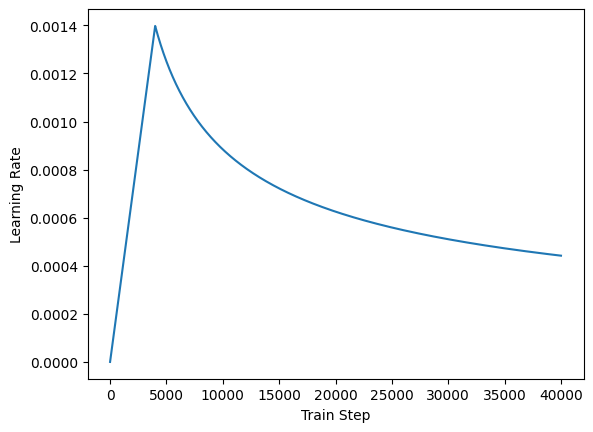

In [ ]:
temp_learning_rate_scheldule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_scheldule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
learning_rate = CustomSchedule(d_model)
#这里我们使用adam优化器,并使用我们自定义的学习率
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


In [ ]:
#这里我们使用稀疏交叉熵损失函数
#from_logits: 为True时，会将y_pred转化为概率（用softmax）,否则不进行转换，通常情况下用True结果更稳定；
#reduction：类型为tf.keras.losses.Reduction，对loss进行处理，默认是求平均；
#这里我们设置为none不进行自动求平均处理，我门后面要定义一个方法去求平均
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    #real 真实值 shape （batch_size, target_seq_len)
    #这里的target_seq_len 要去掉句子开头的start, 所以实际长度要减一
    #pred 预测值 shape （batch_size, tar_seq_len, target_vocab_size)
    #预测值里的tar_seq_len是没有start的，因为start是作为预测的输入，
    #而输出是start后面的第一个单词

    #tf.math.equal(real,0) 表示real里面是0的值表示为true，不是零的表示为false
    #tf.math.logical_not(tf.math.equal(real, 0)) 是把true改成false， false改成true
    mask = tf.math.logical_not(tf.math.equal(real, 0))

    #求损失
    loss_ = loss_object(real, pred)

    #转换数据类型（就是true变成1，false变成0）
    mask = tf.cast(mask, dtype=loss_.dtype)

    #去掉mask对应的值,
    #就是loss位置对应的值和mask对应的位置相乘，mask对应是0的位置loss值也会变成零
    loss_ *= mask

    #求loss平均值
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
def accuracy_function(real, pred):
    #real (batch_size, target_seq_len) 这里的target_seq_len长度根上面loss的real长度一样
    #pred (batch_size, tar_seq_len, target_vocab_size)
    #这里的tar_seq_len和target_seq_len大小是相等的。

    #tf.argmax 取pred里的最大值，axis=2 表示取第3个维度target_vocab_size里的最大值
    #最后shape为（batch_size, tar_seq_len)
    #tf.equal 就是拿real和刚取了最大值的pred进行比较
    #值相等的单词就是true 否则为false
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    #tf.math.equal(real,0) 表示real里面是0的值表示为true，不是零的表示为false
    #tf.math.logical_not(tf.math.equal(real, 0)) 是把true改成false， false改成true
    #mask表示 real里单词不是0的是true， 是零的false
    mask = tf.math.logical_not(tf.math.equal(real,0))

    #表示mask和accuracies相同就用true不同就false
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    #tf.reduce_sum(accuracies)是求有多少个预测正确的单词
    #tf.reduce_sum(mask)是求总共有多少单词。
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

# loss 和 accuracy 使用上面自定义的 loss和 accuracy
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
input_text_processor.vocabulary_size()  #输入，中文单词的数量
output_text_processor.vocabulary_size() #输出，英文单词的数量


7180

In [ ]:
#初始化Transformer类
#num_layers, 表示decodrlayer部件要有几个
#d_model, 表示embedding的深度是多少
#num_heads 表示多头注意力里面的多头数是多少
#dff 表示增加非线性时设置的神经元个数
#input_vocab_size 输入的词典大小
#target_vocab_size 输出的词典大小
#这里的pe_input 就是前面的maximum_position_encoding 最大句子的长度 这里是输入句子的最大长度
#这里的pe_target 就是前面的maximum_position_encoding 最大句子的长度 这里是输出句子的最大长度

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_text_processor.vocabulary_size(),
    target_vocab_size=output_text_processor.vocabulary_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
checkpoint_path = "./checkpoints/cn_en/train" #检测文件保存位置

#检查点保存的内容
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
#max_to_keep=5 要保留的检查点的数
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

#下面的语句作用，如果检查点存在，则恢复最新的检查点
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 20 #我们要进行20次循环训练，大家可以根据效果适当增加和减少


In [ ]:
#定义一个train_step_signature列表
#列表里含有2个被tf.TensorSpec定义的张量
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
train_step_signature

[TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None)]

In [ ]:
#input_signature的好处：
#1.可以限定函数的输入类型，以防止调用函数时调错，
#2．一个函数有了input_signature之后，在tensorflow里边才可以保存成savedmodel。
#在保存成savedmodel的过程中，需要使用get_concrete_function函数把一个tf.function
#标注的普通的python函数变成带有图定义的函数。

# tf.function 模块
#我们仅需加入一个简单的 @tf.function 修饰符，就能轻松将模型以图模式运行！

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    #tf.GradientTape()计算梯度用的
    with tf.GradientTape() as tape:
        #先求出预测值
        predictions, _ = transformer([inp, tar_inp], training=True)
        #计算loss
        loss = loss_function(tar_real, predictions)
    #计算出所有可训练变量的梯度，然后进行下一步的更新
    gradients = tape.gradient(loss, transformer.trainable_variables)
    #优化，应用更新的梯度
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    #应用自定义的 loss和 accuracy函数，求出loss和accuracy
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS): #进行20轮的训练
    start = time.time()

    #没轮开始前重新初始化loss和accuracy值
    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> China, tar -> english
    for (batch, (inp, tar)) in enumerate(train_batches):
        train_step(inp, tar)
        #每50batch打印一次loss和accuray
        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    #每5个epoch保存一次检查点
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
    #每个epoch完后打印一次loss和accuracy
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    #每个epoch完成后打印一次运行所用时间
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.9791 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8920 Accuracy 0.0012
Epoch 1 Batch 100 Loss 8.7227 Accuracy 0.0575
Epoch 1 Batch 150 Loss 8.5675 Accuracy 0.0788
Epoch 1 Batch 200 Loss 8.3967 Accuracy 0.0897
Epoch 1 Batch 250 Loss 8.1970 Accuracy 0.0961
Epoch 1 Batch 300 Loss 7.9677 Accuracy 0.1097
Epoch 1 Batch 350 Loss 7.7285 Accuracy 0.1254
Epoch 1 Batch 400 Loss 7.4921 Accuracy 0.1380
Epoch 1 Batch 450 Loss 7.2731 Accuracy 0.1499
Epoch 1 Loss 7.2020 Accuracy 0.1536
Time taken for 1 epoch: 81.27 secs

Epoch 2 Batch 0 Loss 5.2868 Accuracy 0.2390
Epoch 2 Batch 50 Loss 5.1355 Accuracy 0.2696
Epoch 2 Batch 100 Loss 5.0314 Accuracy 0.2807
Epoch 2 Batch 150 Loss 4.9417 Accuracy 0.2882
Epoch 2 Batch 200 Loss 4.8641 Accuracy 0.2944
Epoch 2 Batch 250 Loss 4.7913 Accuracy 0.3017
Epoch 2 Batch 300 Loss 4.7254 Accuracy 0.3084
Epoch 2 Batch 350 Loss 4.6664 Accuracy 0.3143
Epoch 2 Batch 400 Loss 4.6083 Accuracy 0.3196
Epoch 2 Batch 450 Loss 4.5520 Accuracy 0.3247
Epoch 2 Loss 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Translator(tf.Module):
    def __init__(self, input_text_processor, output_text_processor, transformer):
        self.tokenizers_pt = input_text_processor
        self.tokenizers_en = output_text_processor
        #这里遇到一个问题
        #后面我们要保存模型
        #我们定义一个类并把Translator它包装在另一个tf.Module子类中，这次使用tf.function方法__call__：
        #这时会报一个错误
        #OperatorNotAllowedInGraphError: using a tf.Tensor as a Python bool is not allowed:
        #AutoGraph is disabled in this function. Try decorating it directly with @tf.function.
        #这是因为我把tf.keras.layers.StringLookup放到了__call__方法里
        #把这个方法拿出来，放到初始化里就可以了
        self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))
        self.transformer = transformer

    def __call__(self, sentence, max_length=20):
        #输入中文句子，并添加了开始和结束标记
        #assert判读输入的句子是不是tf.Tensor张量类型
        assert isinstance(sentence, tf.Tensor)

        #如果句子的形状是0，我们给句子加入一个维度
        if len(sentence.shape) == 0:
            sentence = sentence[tf.newaxis]

        #把句子变成相应的数字
        sentence = self.tokenizers_pt(sentence)

        encoder_input = sentence

        #因为目标是英语，所以transformer的第一个标记应该是英语起始标记。
        #这里我们输入一个空句子，产生一个start 和 end 的 token 是[2, 3]
        start_and_end = self.tokenizers_en([''])[0]
        #取出 start的 token 并加入一个维度
        start = start_and_end[0][tf.newaxis]
        #取出 end的 token 并加入一个维度
        end = start_and_end[1][tf.newaxis]


        #在部分网络结构，尤其是涉及到时间序列的结构中，
        #我们可能需要将一系列张量以数组的方式依次存放起来，以供进一步处理。
        #当然，在即时执行模式下，你可以直接使用一个 Python 列表(List)存放数组。
        #不过，如果你需要基于计算图的特性(例如使用 @tf.function 加速模型运行
        #或者使用 SavedModel 导出模型)，就无法使用这种方式了。
        #因此，TensorFlow 提供了 tf.TensorArray ，
        #一种支持计算图特性的 TensorFlow 动态数组。

        #dynamic_size 参数设置为 True ，则该数组会自动增长空间。
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        #write(index, value) ：将 value 写入数组的第 index 个位置;
        output_array = output_array.write(0, start)


        for i in tf.range(max_length):
            #output_array.stack()返回output_array里所有值
            #tf.transpose是转制tensor形状，例如output_array插入2个值后
            #shape是（2，1）tf.transpose变成（1，2）
            output = tf.transpose(output_array.stack())

            #输入句子和output的值产生一个预测值 (batch_size, tar_seq_len, target_vocab_size)
            #这里我们输入的是1个句子，batch_size = 1
            #tar_seq_len 大小是随着output的第二个维度变化的，1，2，3，
            #target_vocab_size 大小是不变的，一直是固定值
            #（1, 1, 8000), (1, 2, 8000), (1, 3, 8000)
            predictions, _ = self.transformer([encoder_input, output], training=False)

            #从seq_len维度中选择最后一个token
            #这样我们每次循环取的就是最后一个单词预测的值
            predictions = predictions[:, -1:, :]

            #取最后一个维度也就是target_vocab_size里的最大值
            predicted_id = tf.argmax(predictions, axis=-1)

            #把预测值添加到output_array
            output_array = output_array.write(i+1, predicted_id[0])

            #如果预测的id值等于end值，说明预测结束，跳出循环
            #如果没有出现end值，那就直到循环结束
            if predicted_id == end:
                break

        #output_array.stack()取出output_array里所有的值
        #也就是我们预测的整个句子，shape是（tokens, 1)
        #tokens 大小就是句子的长度
        #tf.transpose 把output_array变成 （1，tokens）
        output = tf.transpose(output_array.stack())

        #获得所有en_vocab的值
        #output_vocab = np.array(self.tokenizers_en.get_vocabulary())
        # output_vocab = tf.keras.layers.StringLookup(
        #     vocabulary=self.tokenizers_en.get_vocabulary(),
        #     mask_token='', #表示屏蔽输入的标记。就是空值不输入。
        #     invert=True)

        #取出所有预测的单词
        #result_text_tokens = output_vocab[output[0].numpy()]
        result_text_tokens = self.output_token_string_from_index(output)

        #去掉start 和 end
        #text_tokens = result_text_tokens[1:-1]
        text_tokens = result_text_tokens[:, 1:-1]

        #把所有的单词链接成句子
        #text = ' '.join(text_tokens)
        text = tf.strings.reduce_join(text_tokens, axis=1, separator=' ')


        _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

        return text[0], result_text_tokens, attention_weights

In [ ]:
#打印结果
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}') #输入的句子
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}') #预测值
    print(f'{"Ground truth":15s}: {ground_truth}') #网易有道翻译结果

In [ ]:
translator = Translator(input_text_processor, output_text_processor, transformer)


In [ ]:
sentence = "今天天气很好。"
ground_truth = "The weather is fine today."

In [ ]:
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(proce_cn_sentence(sentence)))
print_translation(sentence, translated_text, ground_truth)

Input:         : 今天天气很好。
Prediction     : the weather is very good today .
Ground truth   : The weather is fine today.
